In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
HOUSING_PATH = os.path.join("zestawy_danych", "mieszkania")

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        with tarfile.open(tgz_path) as tgz:
            tgz.extractall(path=housing_path)
        
fetch_housing_data()

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def load_housing_data(housing_data=HOUSING_PATH):
    csv_path = os.path.join(housing_data, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


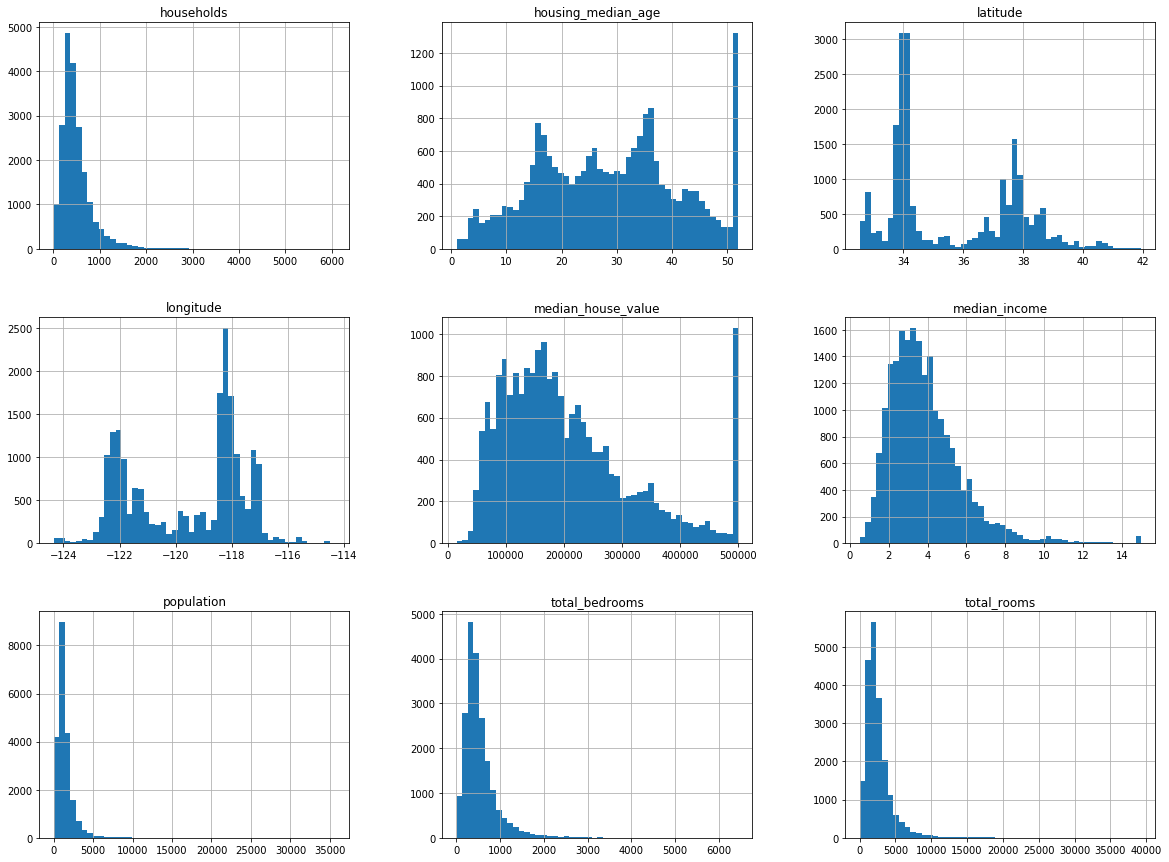

In [8]:
housing.hist(bins=50, figsize=(20,15));

In [9]:
def split_train_test(data, ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print("train:", len(train_set), ", test:", len(test_set))

train: 16512 , test: 4128


In [10]:
import hashlib

def test_set_check(identifier, test_ratio, hash_):
    return hash_(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash_=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash_))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [12]:
# housing_with_id['id'] = housing["longitude"] * 1000 + housing["latitude"]
# train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [13]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

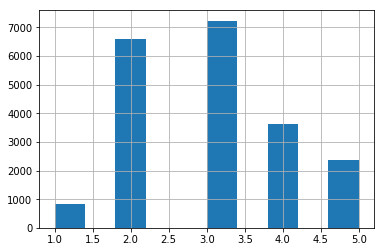

In [14]:
housing["income_cat"].hist();

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(f"train: {len(train_set)}, test: {len(test_set)}")

train: 16512, test: 4128


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set  = housing.loc[test_index]
    
print(f"train: {len(strat_train_set)}, test: {len(strat_test_set)}")

train: 16512, test: 4128


In [17]:
strat = strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [18]:
rand_ = test_set["income_cat"].value_counts() / len(test_set)

In [19]:
whole = housing["income_cat"].value_counts() / len(housing)

In [20]:
rand_error = (whole - rand_)/whole * 100
strat_error = (whole - strat)/whole * 100

In [21]:
strat.rename('l. warstwowe', inplace=True)
rand_.rename('losowe', inplace=True)
whole.rename('łącznie', inplace=True)
rand_error.rename('błąd - losowe %', inplace=True)
strat_error.rename('błąd - warstwowe %', inplace=True)

pd.concat([strat, rand_, whole, rand_error, strat_error], axis=1, sort=True)

,l. warstwowe,losowe,łącznie,błąd - losowe %,błąd - warstwowe %
1.0,0.039729,0.040213,0.039826,-0.973236,0.243309
2.0,0.318798,0.324370,0.318847,-1.732260,0.015195
3.0,0.350533,0.358527,0.350581,-2.266446,0.013820
4.0,0.176357,0.167393,0.176308,5.056334,-0.027480
5.0,0.114583,0.109496,0.114438,4.318374,-0.127011


In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# NEXT STAGE

In [52]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


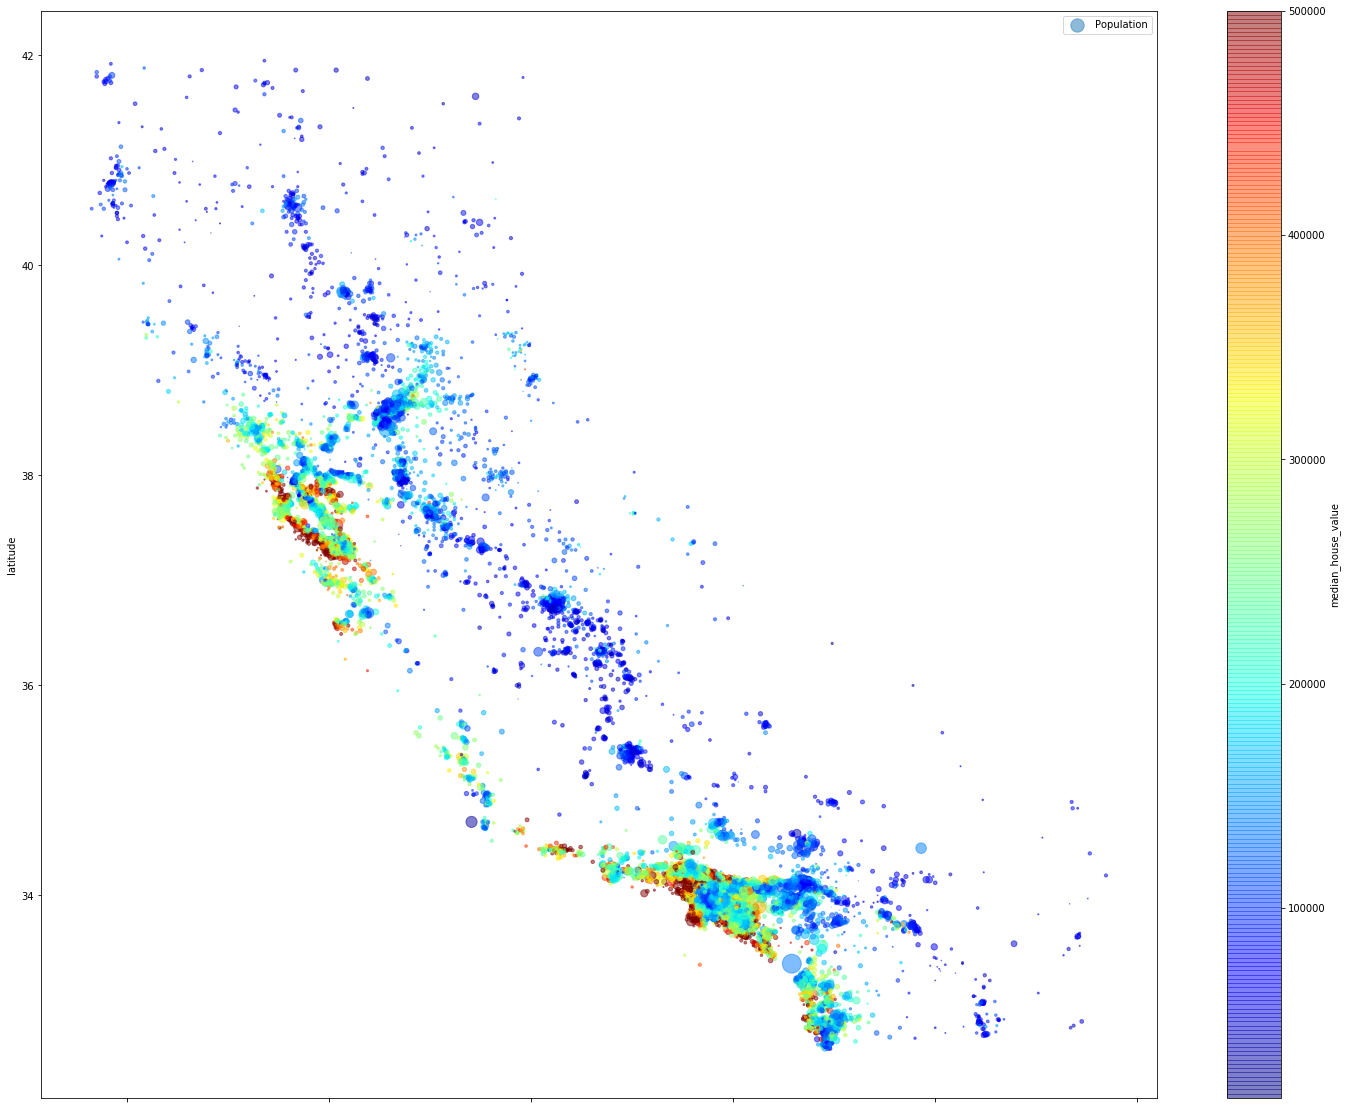

In [53]:
housing.plot(kind='scatter', x='longitude', y='latitude', 
             figsize=(25,20), alpha=0.5, 
             s=housing["population"]/100, label="Population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True);
plt.legend();

### można dodać clustering z wizualizacją

In [54]:
corr_matrix = housing.corr()

In [55]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [56]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

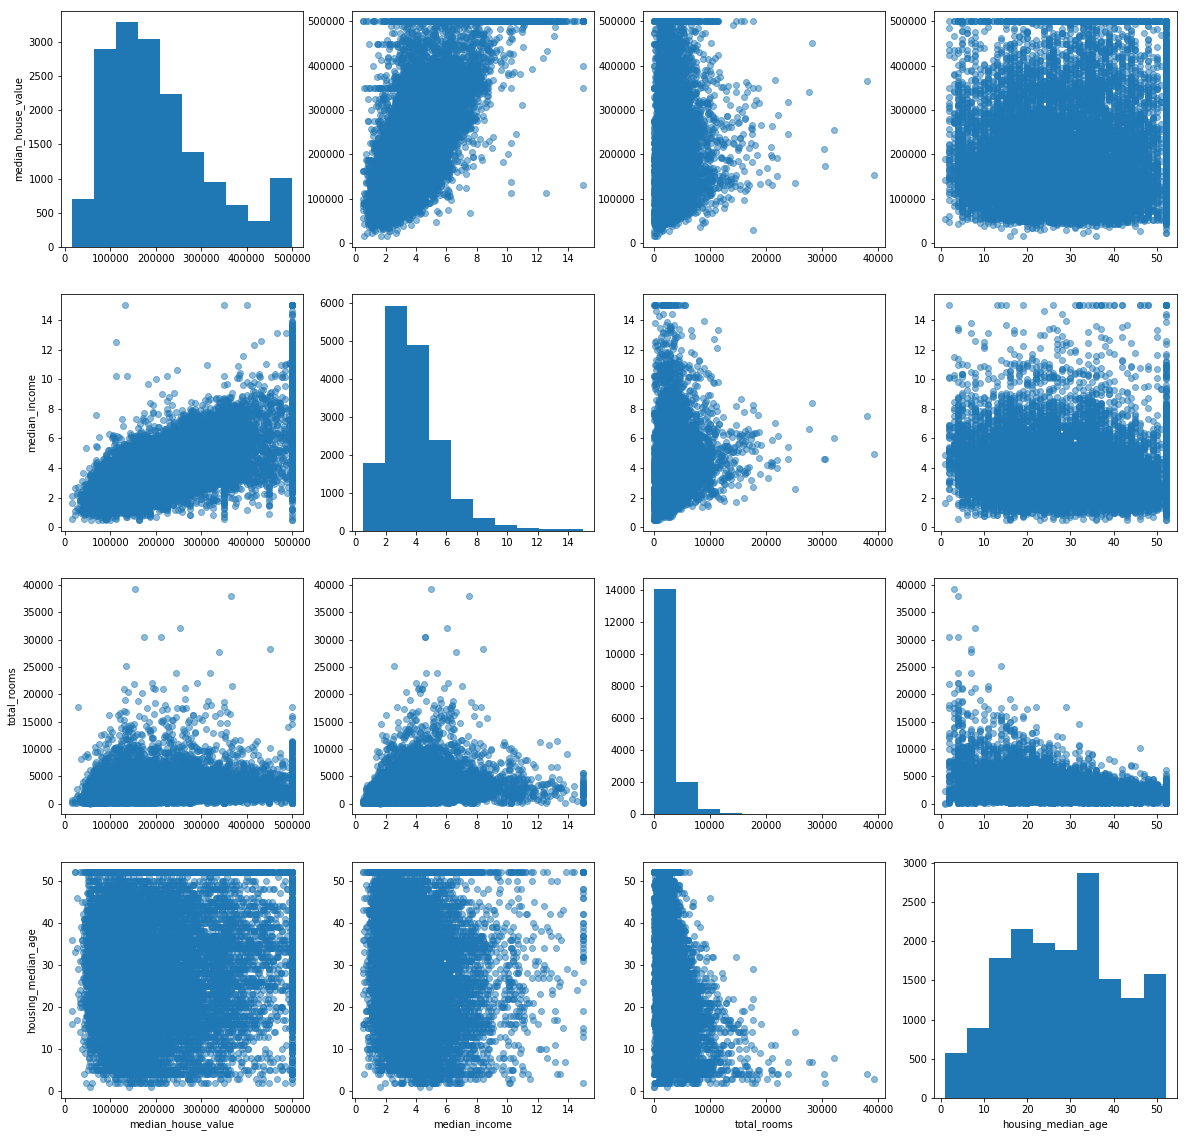

In [59]:
plt.figure(figsize=(20,20))
k = len(attributes)
for i in range(k):
    for j in range(k):
        plt.subplot(k, k, (k*i)+j+1)
        if j == 0:
            plt.ylabel(attributes[i])
        if i == k-1:
            plt.xlabel(attributes[j])
        if i == j:
            plt.hist(housing[attributes[j]])
        else:    
            plt.scatter(housing[attributes[j]], housing[attributes[i]], alpha=0.5)

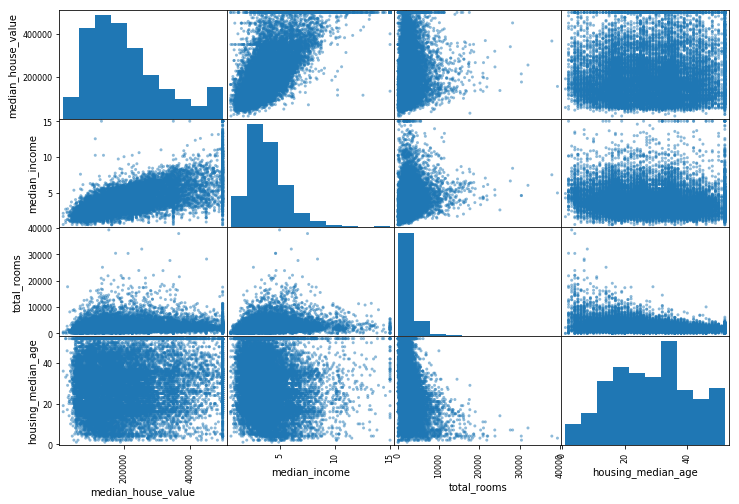

In [58]:
scatter_matrix(housing[attributes], figsize=(12, 8));

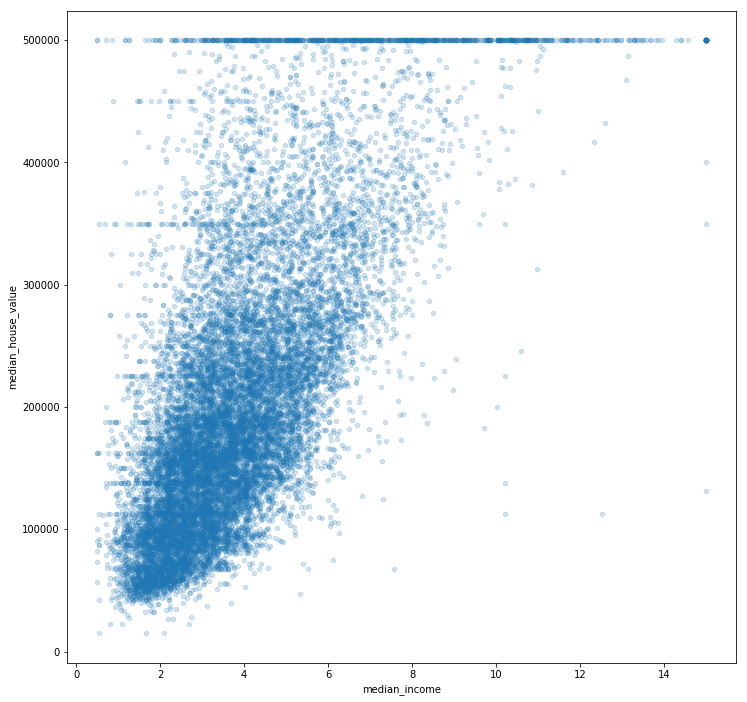

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.2, figsize=(12,12));

In [31]:
housing["Pokoje_na_rodzinę"] = housing["total_rooms"] / housing["households"]
housing["Sypialnie_na_pokoje"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["Populacja_na_rodzinę"] = housing["population"] / housing["households"]

In [32]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687160
Pokoje_na_rodzinę       0.146285
total_rooms             0.135097
housing_median_age      0.114110
households              0.064506
total_bedrooms          0.047689
Populacja_na_rodzinę   -0.021985
population             -0.026920
longitude              -0.047432
latitude               -0.142724
Sypialnie_na_pokoje    -0.259984
Name: median_house_value, dtype: float64

# Data Preparation

In [60]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [61]:
# housing.dropna(subset=["total_bedrooms"])
# housing.drop("total_bedrooms", axis=1)
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [62]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [63]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [72]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)
print(encoder.classes_)

[0 0 4 ... 1 0 3]
['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [77]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories="auto")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [86]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [89]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int32'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [92]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        pokoje_na_rodzine = X[:, rooms_ix] / X[:, household_ix]
        populacja_na_rodzine = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            sypialnie_na_pokoje = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, pokoje_na_rodzine, populacja_na_rodzine, sypialnie_na_pokoje]
        else:
            return np.c_[X, pokoje_na_rodzine, populacja_na_rodzine]

In [101]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

In [112]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

normalizer = MinMaxScaler()
housing_normalized = normalizer.fit_transform(housing_tr)
pd.DataFrame(housing_normalized, columns=housing_num.columns).describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,0.475515,0.329392,0.542218,0.066560,0.085696,0.039709,0.092431,0.232803
std,0.199388,0.227211,0.246563,0.054394,0.066179,0.031270,0.070150,0.131374
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.148778,0.333333,0.036552,0.047358,0.021890,0.051718,0.142541
50%,0.581673,0.182784,0.549020,0.053759,0.069427,0.032540,0.075803,0.209721
75%,0.631474,0.550478,0.705882,0.079743,0.102932,0.048103,0.112024,0.292725
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
standarizer = StandardScaler()
housing_standarized = standarizer.fit_transform(housing_tr)
pd.DataFrame(housing_standarized, columns=housing_num.columns).describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-4.272678e-15,2.275755e-15,-2.700521e-16,8.606884e-17,1.181562e-16,-4.347735e-17,9.614940e-18,-2.225960e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00


# Pipelines